# Comparing Effect Estimators on Fast-food Employment Data

We look at the famous Card and Krueger study[1] of the impact of a minimum wage change on employment levels in fast food restaurants near the border of New Jersey and Pennsylvania. The treatment in this case was whether the restaurant was in a state which enacted a minimum wage increase (in this case NJ), the outcome is the total number of employees per branch after the change of the law and many covariates were collected for controlling, as detailed below. 

The naive estimation would show that raising the minimum wage causes a decrease in number of employees hired per restaurant. However, once we correct for the covariates we find that in fact there was no such effect and that there may have been an increase in employment following the minimum wage increase.

This notebook demonstrates how `causallib` enables causal effect estimation using different methods easily, by utilizing a consistent API.

[1] : Card, D. & Krueger, A. Minimum Wages and Employment: A Case Study of the Fast Food Industry in New Jersey and Pennsylvania. w4509 http://www.nber.org/papers/w4509.pdf (1993) doi:10.3386/w4509.

## Data 

We begin by obtaining the data from Card's website.

In [1]:
import pandas as pd
import numpy as np
import warnings


def load_card_krueger(select_covariates=["EMPTOT", "WAGE_ST", "INCTIME", "BK", "KFC", "ROYS", "WENDYS"], outcome="EMPTOT2", dropna=True, include_managers=False):
    """
    Load data on the effect of a change in minimum wage laws on fast food employment

    Loads data from the study by Card and Krueger [1].  Data downloads from Card's website.

    Args:
        select_covariates (list) : List of covariates to return. The default list is based on the analysis by Imbens and Rubin [2].
            To return all covariates pass an empty list: []
        outcome (str) : Name of column to use as outcome. Defaults to total employees after minimum wage change.
        dropna (bool) : Whether to remove columns with NaN in the select_covariates or outcome columns.
        include_managers (bool) : Whether to include managers in employee count. Card & Krueger include them, Imbens & Rubin
            do not include them. (default: False)

    Returns:
        databunch (Bunch) : Bunch with member `x`,`a`, `y` and descriptors corresponding to covariates, 
        treatment (New Jersey vs Pennsylvania), outcome, and descriptors as parsed 
        from the codebook file distributed by Card.

    [1] : Card, D. & Krueger, A. Minimum Wages and Employment: A Case Study of the Fast Food Industry in New Jersey and Pennsylvania. 
        w4509 http://www.nber.org/papers/w4509.pdf (1993) doi:10.3386/w4509.
    [2] : Imbens, G.W. & Rubin D.B., Causal Inference for Statistics, Social, and Biomedical Sciences: An Introduction, Chapter 18, 
        (Cambridge University Press, 2015)


    """
    import requests
    import zipfile
    from io import BytesIO, TextIOWrapper
    from sklearn.utils import Bunch

    r = requests.get("https://davidcard.berkeley.edu/data_sets/njmin.zip")
    z = zipfile.ZipFile(BytesIO(r.content))
    df = pd.read_csv(z.open("public.dat"), engine="python", sep="\s+",
                     header=None).applymap(lambda x: pd.to_numeric(x, errors="coerce"))

    # Load column names and descriptions from `codebook`
    codebook = [repr(line)
                for line in TextIOWrapper(z.open("codebook"), "cp437")]
    # part of the codebook is not relevant
    codes = codebook[7:11] + codebook[13:19] + \
        codebook[21:38] + codebook[40:59]
    cols = [i.strip("'\" ").split()[0] for i in codes]
    descriptions = [" ".join(i.strip("'\" ").split()[
                             4:]).rstrip('\\n') for i in codes]
    column_descriptions = dict(zip(cols, descriptions))
    df.columns = cols

    # Calculate total employment following Card and Krueger's method
    if include_managers:
        df = df.assign(EMPTOT=df.EMPFT + 0.5 * df.EMPPT + df.NMGRS)
        column_descriptions["EMPTOT"] = "Initial total employment (full_time_employees + managers + 0.5*part_time_employees)"
        df = df.assign(EMPTOT2=df.EMPFT2 + 0.5 * df.EMPPT2 + df.NMGRS2)
        column_descriptions["EMPTOT2"] = "Final total employment (full_time_employees + managers + 0.5*part_time_employees)"
    else:
        # Calculate total employment following Imbens and Rubin's method
        df = df.assign(EMPTOT=df.EMPFT + 0.5 * df.EMPPT)
        column_descriptions["EMPTOT"] = "Initial total employment (full_time_employees + 0.5*part_time_employees)"
        df = df.assign(EMPTOT2=df.EMPFT2 + 0.5 * df.EMPPT2)
        column_descriptions["EMPTOT2"] = "Final total employment (full_time_employees + 0.5*part_time_employees)"

    #df = pd.get_dummies(df,prefix="name",drop_first=True,columns=["CHAIN"]).rename(columns=dict(name_1="KFC",name_2="ROYS",name_3="WENDYS"))
    df = pd.get_dummies(df, prefix="name", drop_first=False, columns=["CHAIN"]).rename(
        columns=dict(name_1="BK", name_2="KFC", name_3="ROYS", name_4="WENDYS"))
    column_descriptions.update(dict(BK="is branch of Burger King", KFC="is branch of KFC",
                                    ROYS="is branch of Roy's", WENDYS="is branch of Wendy's"))
    select_covariates = [i for i in select_covariates if i in df.columns]
    if dropna:
        if select_covariates:
            df = df.dropna(subset=select_covariates + ["STATE", outcome])
        else:
            df = df.dropna()

    # Divide data into pre-intervention and post-intervention variables
    x = df[[c for c in df.columns if "2" not in c]]

    y = df[[c for c in df.columns if "2" in c]]
    y = df.pop(outcome)

    a = x.pop("STATE")

    if select_covariates:
        x = x[select_covariates]
    return Bunch(X=x, a=a, y=y, descriptors=pd.Series(column_descriptions))

Card and Krueger studied the impact of an increase in the minimum wage in NJ on levels of employment in NJ and the adjacent area in PA. They included many covariates in the survey. Here we will use the subset used by Imbens and Rubin in their analysis of this data in "Causal Inference for Statistics, Social, and Biomedical Sciences".

In [2]:
data = load_card_krueger()
X, a, y = data.X, data.a, data.y
data.X.join(data.a).join(data.y).head()

,EMPTOT,WAGE_ST,INCTIME,BK,KFC,ROYS,WENDYS,STATE,EMPTOT2
3,30.0,5.00,26.0,0,0,0,1,0,18.0
4,19.0,5.50,52.0,0,0,0,1,0,29.5
6,67.5,5.00,26.0,1,0,0,0,0,24.0
7,18.5,5.00,52.0,1,0,0,0,0,30.5
8,6.0,5.25,13.0,0,1,0,0,0,9.0


In [3]:
data.descriptors.loc[data.X.join(data.a).join(data.y).columns]

EMPTOT     Initial total employment (full_time_employees ...
WAGE_ST                                 starting wage ($/hr)
INCTIME                          months to usual first raise
BK                                  is branch of Burger King
KFC                                         is branch of KFC
ROYS                                      is branch of Roy's
WENDYS                                  is branch of Wendy's
STATE                                      1 if NJ; 0 if Pa 
EMPTOT2    Final total employment (full_time_employees + ...
dtype: object

After loading the data, we begin by checking the association between treatment and outcome, without any causal inference.

In [4]:
naive_ate = data.y[data.a == 1].mean() - data.y[data.a == 0].mean()
print(
    f"NJ fast food restaurants had a change of {naive_ate:.5f} employees compared to PA fast food restaurants.")

NJ fast food restaurants had a change of -0.21974 employees compared to PA fast food restaurants.


Based on this, we would conclude that the increase in minimum wage in fact decreased employment levels in fast food restaurants, because the level of employment in the treated group (NJ) was lower than the untreated group (PA). However, this inference would only be justified if the restaurants in NJ and PA were otherwise equivalent. Let us utilize the provided `calculate_covariate_balance` function to check that now:

In [5]:
from causallib.evaluation.metrics import calculate_covariate_balance

calculate_covariate_balance(X, a, w=a*0+1)["unweighted"].sort_values()

covariate
ROYS       0.001462
BK         0.015325
WAGE_ST    0.038154
INCTIME    0.080553
WENDYS     0.127842
KFC        0.142869
EMPTOT     0.195605
Name: unweighted, dtype: float64

In [6]:
X.groupby(a).mean()

,EMPTOT,WAGE_ST,INCTIME,BK,KFC,ROYS,WENDYS
STATE,,,,,,,
0,20.172794,4.623382,19.051471,0.426471,0.132353,0.250000,0.191176
1,17.273297,4.604803,17.691756,0.415771,0.207885,0.250896,0.125448


Here we see that the untreated state (PA) had quite a bit higher employment levels `EMPTOT` than the treated state (NJ) prior to the intervention. Could it be that the measured decline in employment in NJ is in fact explained by the prior lower number of employees per branch? In order to answer this question we need to estimate the difference in counterfactual outcomes:
$$ATE = E[Y^{a=1}] - E[Y^{a=0}]$$
The fundamental problem of causal inference is that for each sample we need _both_ treated and untreated outcomes, but in reality no sample was both treated and untreated. Causal inference has many ways to estimate this quantity and `causallib` implements several of them, using a uniform API. To assess the effects, we will load many estimators and compare their results. Note how the same API calls can be used, even though the underlying estimation may be very different. Here we do not focus on the details of the implementation and how each method may be tweaked. To understand the details, you can reference the documentation for each method. 

In [7]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from matplotlib import pyplot as plt
from causallib.estimation import (
    PropensityFeatureStandardization,
    WeightedStandardization,
    AIPW,
    IPW,
    MarginalOutcomeEstimator,
    Standardization,
    StratifiedStandardization,
    Matching,
    PropensityMatching,
)
from causallib.preprocessing.transformers import MatchingTransformer


def learner(): return LogisticRegression(
    solver="liblinear", class_weight="balanced", max_iter=5000)


def makeipw(): return IPW(learner=learner())
def makestd(): return StratifiedStandardization(learner=LinearRegression())


all_estimators = [
    MarginalOutcomeEstimator(learner=LinearRegression()),
    Matching(with_replacement=False),
    PropensityMatching(learner=learner(), caliper=0.1),
    IPW(learner=learner()),
    Standardization(learner=LinearRegression()),
    StratifiedStandardization(learner=LinearRegression()),
    PropensityFeatureStandardization(makestd(), makeipw()),
    WeightedStandardization(makestd(), makeipw()),
    AIPW(makestd(), makeipw()),
]


def get_all_estimates(X, a, y):
    estimates = {}
    for estimator in all_estimators:
        estimator.fit(X, a, y)
        estimator_name = estimator.__class__.__name__
        estimates[estimator_name] = estimator.estimate_population_outcome(
            X, a, y)
    estimates_df = pd.concat(estimates, axis=1).T
    return estimates_df

The estimators in `causallib` share a similar API, all of them implementing `fit` and `estimate_population_outcome`. This allows us to easily try them all to see whether they are in agreement as to the causal effect. There is also a dummy estimator `MarginalOutcomeEstimator` which simply implements the naive estimate shown above. 

In [8]:
warnings.filterwarnings('ignore')
all_estimates = get_all_estimates(X, a, y)
all_estimates.assign(ATE=all_estimates[1] - all_estimates[0])

,0,1,ATE
MarginalOutcomeEstimator,17.544118,17.324373,-0.219745
Matching,17.544118,18.647059,1.102941
PropensityMatching,17.422190,17.725504,0.303314
IPW,16.967157,18.135547,1.168390
Standardization,16.285505,17.631131,1.345626
StratifiedStandardization,16.664511,17.672040,1.007530
PropensityFeatureStandardization,16.686028,17.638321,0.952293
WeightedStandardization,16.625123,17.667617,1.042494
AIPW,16.653759,17.673968,1.020210


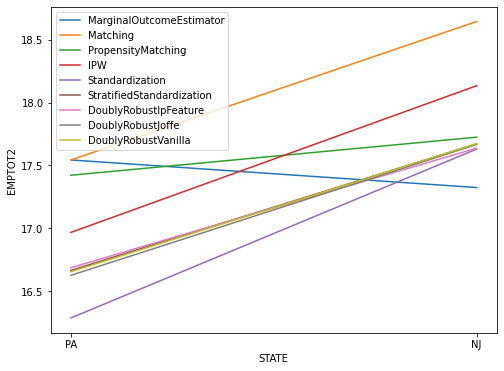

In [9]:
f, ax = plt.subplots(figsize=(8, 6))
all_estimates.T.plot(ax=ax)
ax.set_ylabel(y.name)
ax.set_xlabel(a.name)
plt.xticks([0, 1], ["PA", "NJ"]);

The most striking thing that we see in this figure is that all of the estimators except one show an increase in total employment under the intervention. The only one which does not show an increase is `MarginalOutcomeEstimator`. As its name suggests, this is an estimator that assumes marginal exchangeability, ie it does not correct for any confounders.

All of the causal inference methods work by estimating what would have happened if the same sample with the same covariates received a treatment other than the one it actually received. Each of the causal methods shifted the estimate of `EMPTOT2` down for PA and, to a lesser extent, up for NJ. 

# Reweighting with IPW
Above we saw that the original sample was imbalanced in the sense that the distribution of covariates (especially `EMPTOT`) was highly unequal between the treated and control groups. Balancing the two groups is one of the central challenges of causal inference and it can be accomplished by either reweighting the samples or by restricting the analysis to a subset of the data which is balanced. The first method, reweighting is accomplished by the IPW estimator:

In [10]:
ipw = IPW(learner=LogisticRegression(solver="liblinear", class_weight="balanced"))
ipw.fit(X, a)
w = ipw.compute_weights(X, a)
calculate_covariate_balance(X, a, w)

abs_smd,weighted,unweighted
covariate,,
EMPTOT,0.000816,0.195605
WAGE_ST,0.031575,0.038154
INCTIME,0.008160,0.080553
BK,0.006652,0.015325
KFC,0.006516,0.142869
ROYS,0.009877,0.001462
WENDYS,0.009438,0.127842


We can see that most of the variables are now balanced, especially `EMPTOT`. This gives us confidence that the estimated outcome is indeed an "apples to apples" comparison, after weighting.

# Restricting the sample with Matching
Another way to deal with imbalanced covariates is to only include comparisons between treated and control samples which are very similar. There are a variety of ways in which this can be accomplished. One of the most common is matching by propensity score. Here we will consider the case without replacement, where the data set is restricted to a sequence of pairs where each pair has exactly one treatment and one control, and each sample can appear at most once.

We do not want to match on the covariates, but rather on the propensity score. To do this we use the `PropensityTransformer` object as a `propensity_transform` within the `MatchingTransformer`.

In [11]:
from causallib.preprocessing.transformers import PropensityTransformer
propensity_transform = PropensityTransformer(learner=learner(), include_covariates=True)

The propensity model will be autmatically fit when the `MatchingTransformer` is fit.

In [12]:
mt = MatchingTransformer(with_replacement=False, propensity_transform=propensity_transform)
Xm, am, ym = mt.fit_transform(X, a, y)
print(f"Transforming data from {X.shape[0]} samples to {Xm.shape[0]} samples by matching without replacement.")

Transforming data from 347 samples to 136 samples by matching without replacement.


We can now check the covariate balance of the resulting data directly and also with propensity weights:

In [13]:
ipw_m = IPW(learner=learner())
ipw_m.fit(Xm, am)
wm = ipw_m.compute_weights(Xm, am)
calculate_covariate_balance(Xm, am, wm)

abs_smd,weighted,unweighted
covariate,,
EMPTOT,0.005456,0.039639
WAGE_ST,0.028619,0.030309
INCTIME,0.003309,0.047924
BK,0.001717,0.021077
KFC,0.001242,0.000000
ROYS,0.001137,0.000000
WENDYS,0.004414,0.026073


At this point we have substantially smaller covariate imbalance, but we are using only ~40% of the data.  We can now check the estimates directly on the matched subset.

In [14]:
all_estimates_matched = get_all_estimates(Xm, am, ym)
all_estimates_matched.assign(ATE=all_estimates_matched[1] - all_estimates_matched[0])

,0,1,ATE
MarginalOutcomeEstimator,17.544118,19.084559,1.540441
Matching,17.544118,19.084559,1.540441
PropensityMatching,17.645221,17.856618,0.211397
IPW,17.438962,19.157859,1.718897
Standardization,17.431120,19.197557,1.766437
StratifiedStandardization,17.431684,19.198245,1.766561
PropensityFeatureStandardization,17.500168,18.502095,1.001927
WeightedStandardization,17.429642,19.192642,1.763000
AIPW,17.429092,19.193340,1.764248


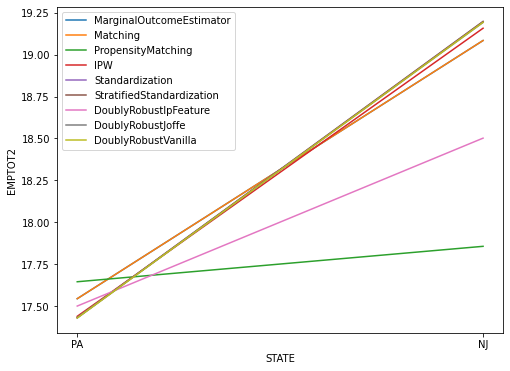

In [15]:
f, ax = plt.subplots(figsize=(8, 6))
all_estimates_matched.T.plot(ax=ax)
plt.ylabel(y.name)
plt.xlabel(a.name)
plt.xticks([0, 1], ["PA", "NJ"]);

In this case `Matching` and `MarginalOutcomeEstimator` are in fact identical because the solution to the matching problem is the same on the matched data. Once again, we see that all of the methods find a slight positive effect.